# Look into discovery significance

In [14]:
import numpy as np, pandas as pd
import os, sys
from pathlib import Path
import importlib.util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

data_dir = os.path.abspath("")

spec = importlib.util.spec_from_file_location("utils", data_dir + '\\utils.py')
u = importlib.util.module_from_spec(spec)
spec.loader.exec_module(u)

# Different Model Architectures

Three different model architectures are used to create a prediction. These are Wide and Deep neural networks, XGB Classifiers and Random Forest (RF) Classifiers.

## Neural Network

For the computation of the Neural Network, the [PyTorch](https://pytorch.org/) python library was used. Specifically, a Wide and Deep model is used, so an ensemble model that cobines a wide linear model for memorization and a deep neural network for generalization.

### Wide and Deep Neural Network

A Wide and Deep neural network consists of two parts that both use Dense Layers, the so called 'Wide' and 'Deep' models, which then get combined into a single model.

#### Wide Neural Network

The Wide model has one Linear Layer that maps the samples to a single output. A Wide linear model helps with memorization and to recognize simple connections between the features, that might get lost in deeper neural networks.

#### Deep Neural Network

The 'Deep' part uses multiple blocks of layers, which we call 'Dense Blocks', followed by a single Linear Layer that maps the number of output features of the last Dense Block to a single output. Each Dense Block consists of a Linear Layer that maps some number of input samples to some number of output samples, followed by a Batch Normalization Layer, followed by an Activation Layer, and lastly a Dropout Layer. The Deep model helps with generalization and to find more complex connections between the features.

The outputs of the Wide and the Deep models are then combined. For a logistic regression problem, the combined models prediction for the sample $x_i$ is 
<a id="eq1"></a>
$$
p_i = \sigma \left( r \cdot \textbf{w}_{Wide} + (1-r) \cdot \textbf{w}_{Deep} + b \right) \tag{1}
$$
where $\sigma$ is the Sigmoid function, $r=0.5$ is the ratio between the Wide and Deep model outputs, $\textbf{w}_{Wide}$ and $\textbf{w}_{Deep}$ are the outputs of the Wide and the Deep model and $b$ is the bias.

### Evaluating model performance

The model performance was evaluated using Receiver Operating Characteristic (ROC) curves. Specifically, the area under the ROC curve (AUC).

ROC curves are used to illustrate the performance of a binary classifier model and they show the true positive rate plotted against the false positive rate. The AUC is the area under the ROC curve. If a model is random, the AUC score is 0.5, and if a model is perfect it is 1.

### Loss function

The loss function Binary Cross Entropy (BCE) is used. The BCE loss is given by:
<a id="eq2"></a>
$$
l(p_i, y_i) = -\frac{1}{N} \sum_{i_1}^N \left[ y_i \cdot log(p_i) + (1-y_i) \cdot log(1-p_i) \right] \tag{2}
$$
where $y_i$ is the correct label of the sample $x_i$ and $N$ is the batch size. Specifically, the command BCEWithLogitsLoss from pytorch is used. This combines a Sigmoid layer with the pytorch's BCELoss command and is more numerically stable than using a Sigmoid layer followed by BCELoss.

### Learning Rate

For both the DL models of the HIGGS and the SUSY datasets, cosine annealing was used for the learning rate reduction. Specifically, the learning rate was reduced from the value $\eta_{max}$ to $\eta_{min}$ by some epoch $T_{max}$ by using cosine annealing. After the epoch $T_{max}$, the learning rate was kept constant at a value of $\eta_{min}$. This resulted in better model performances compared to other learning rate reduction techniques. The learning rate at epoch $T+1$ given by cosine annealing is:
<a id = "eq3"> </a>
$$
\eta_{t+1} = \begin{cases} \eta_{min} + \dfrac{1}{2} \left( \eta_{max} - \eta_{min} \right) \left( 1 + cos\left( \dfrac{T_{cur}\pi}{T_{max}} \right) \right), & T_{cur} < T_{max} \\ \eta_{min}, & T_{cur} >= T_{max} \end{cases} \tag{3}
$$
where $T_{cur}$ is the current epoch.

### Early stopping

For both the HIGGS and the SUSY dataset, the same early stopping was used. If the loss of the validation set did not improve over ten consecutive iterations, the training was stopped. Whenever the AUC score of the validation set improved, the model of that iteration was saved. The best model that was used after the training was the last saved model obtained this way.

## XGBClassifier

The [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) method from the [xgboost]( https://github.com/dmlc/xgboost) python library is used to get this model. The XGB Classifier builds a number of weak learners, in this case they are decision trees, and combines them in one ensemble model for which the final prediction is a weighted sum of the predictions from the weak learners. These weak learners are not trained independently, but sequentially while trying to minimize a loss function. For the binary classification task we try to solve, a logistic loss is used:
<a id = "eq4"> </a>
$$
L(\mathbf{y}, \mathbf{p}) = -\sum^n_{i=1} \left( y_i \cdot log(p_i) + \left( 1-y_i \right) \cdot log(1-p_i) \right) = -\sum^n_{i=1} l(y_i, p_i)
$$
with $y_i$ the correct label of the $\textit{i}\mathrm{th}$ sample $x_i$ and $p_i$ its predicted value and $n$ the number of samples.

Specifically, the model is first initialized with a constant value
$$
\hat{f}_{(0)}(x) = \underset{\theta}{\mathrm{argmin}} \sum^n_{i=1} l(y_i, \theta)
$$
for all inputs where $\hat{f}_{(m)}(x)$ is the prediction of the model after the $\textit{m}\mathrm{th}$ boosting round. $\hat{f}_{(m)}(x)$ is given by
$$
\hat{f}_{(m)}(x) = \sum^m_{k=1} f_k(x)
$$
where $f_k(x)$ is the prediction of the $\textit{k}\mathrm{th}$ tree. To get the $\textit{m}\mathrm{th}$ tree, the gradient $g_i$ and hessian $h_i$ of the loss function after the $\textit{(m-1)}\mathrm{th}$ boosting round are evaluated, where $g_i$ and $h_i$ are defined as
$$
g_i = \left[ \frac{\partial l(y_i, f(x_i))}{\partial f(x_i)} \right]_{f(x) = \hat{f}_{(m-1)}(x)}
$$
$$
h_i = \left[ \frac{\partial^2 l(y_i, f(x_i))}{\partial f(x_i)^2} \right]_{f(x) = \hat{f}_{(m-1)}(x)}
$$
These are then used to define the optimization goal of th $\textit{m}\mathrm{th}$ tree
$$
\sum^n_{i=1} \left[ g_i f_{m}(x_i) + \frac{1}{2} h_i f_m^2(x_i) \right]
$$
This description is a simplification, and in reality there is also another term $\omega(f_m)$ which is the regularization term, sometimes also called complexity of a tree. The full calculations can be seen in the [documentation of the library](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

## Random Forest Classifier

To get the RF Classifier, the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) method from the [scikit-learn](https://scikit-learn.org/stable/index.html) python library is used. The RF Classifier builds some number of trees and combines their predictions, similar to the XGB Classifier. But unlike in the XGB Classifier, the RF Classifier trains the trees independently on random subsets of the data and features. Another difference between the two classifiers is that the RF Classifier gets its final prediction by a majority vote of the individual trees, while the XGB Classifier uses a weighted sum.

This means that a RF Classifier is less prone to overfitting compared to the XGB Classifier, but should generally also perform worse if the hyperparameters are tuned correctly for both classifiers because of the additional steps in the XGB Classifier. Consequently the XGB Classifier takes more time and resources to train than the RF Classifier. This is aplified further because the trees in the RF Classifier can be trained in parallel, while they have to be trained sequentially for the XGB Classifier.

# Load the Correct Labels

The correct labels for each sample need to be fetched. This takes a couple of minutes.

In [2]:
HIGGS_train_labels, HIGGS_valid_labels = u.get_HIGGS_labels()
SUSY_train_labels, SUSY_valid_labels = u.get_SUSY_labels()

print(f"Number of samples in the HIGGS training set: {len(HIGGS_train_labels)}")
print(f"Number of samples in the HIGGS validation set: {len(HIGGS_valid_labels)}")
print()
print(f"Number of samples in the SUSY training set: {len(SUSY_train_labels)}")
print(f"Number of samples in the SUSY validation set: {len(SUSY_valid_labels)}")

Number of samples in the HIGGS training set: 10500000
Number of samples in the HIGGS validation set: 500000

Number of samples in the SUSY training set: 4500000
Number of samples in the SUSY validation set: 500000


# HIGGS Dataset

The HIGGS Dataset has a total of $11$ million samples. $1.05 \times 10^{7}$ of these are used to train the models, and the remaining $5 \times 10^{5}$ for the validation. The HIGGS Dataset consists of 28 features. 21 of these are low-level features and 7 high-level features, that are derived from the low-level features.

## Deep Learning model

As a first step, we look at the deep learning model in more detail.

### Model architecture

As stated before, the DL model uses a Wide and Deep architecture. The Wide model uses the following architecture:

    ==========================================================================================
    Layer                                    Output Shape              Param #
    ==========================================================================================
    Wide                                     [2048, 1]                 --
    │    Linear:                             [2048, 1]                 29
    ==========================================================================================
    Total params: 29
    Trainable params: 29
    ==========================================================================================

For the deep model, a total of eight Dense Blocks were used, all using a dropout rate of 0.2. The first Dense Block takes 28 inputs and gives 2048 outputs using a GELU activation. The next seven Dense Blocks all take 2048 inputs and give 2048 outputs. The first six of these Dense Blocks also use a GELU activation. The last one uses an Tanh activation. After the eight Dense Blocks a single Linear Layer is applied, taking 2048 inputs and mapping them to a single output. The specific architecture can be viewed below:

    ==========================================================================================
    Layer                                    Output Shape              Param #
    ==========================================================================================
    Deep                                     [2048, 1]                 --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              59,392
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─GELU:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    DenseBlock:                         [2048, 2048]              --
    │       └─Linear:                        [2048, 2048]              4,196,352
    │       └─BatchNorm1d:                   [2048, 2048]              4,096
    │       └─Tanh:                          [2048, 2048]              --
    │       └─Dropout:                       [2048, 2048]              --
    │    Linear:                             [2048, 1]                 2,049
    ==========================================================================================
    Total params: 29,468,673
    Trainable params: 29,468,673
    ==========================================================================================

For the Deep model, the dropout rate is set to $p=0.2$ for each Dropout Layer.

For the prediction of the combined model equation [1](#eq1).


### Training of the HIGGS Deep learning model

The training lasted a total of 121 epochs. The learning rate at epoch 0 was set to $\eta_{max} = 1e-3$ and was reduced with cosine annealing to $\eta_{min} = 1e-10$ by epoch 100  as described in equation [2](#eq2). A plot depicting the learning rate against the epoch can be seen in the figure below.

In [3]:
HIGGS_DL_train_info = pd.read_csv(data_dir + "\\HIGGS\\DL info\\best_train_info.csv")
HIGGS_DL_valid_info = pd.read_csv(data_dir + "\\HIGGS\\DL info\\best_valid_info.csv")

HIGGS_DL_total_epochs = HIGGS_DL_valid_info.shape[0]

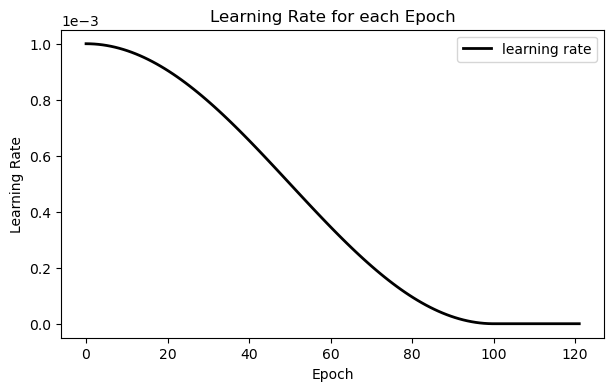

In [15]:
u = importlib.util.module_from_spec(spec)
spec.loader.exec_module(u)

HIGGS_DL_lr = np.vectorize(lambda epoch: u.CosineAnnealing_lr(epoch, 1e-3, 1e-10, 100))

HIGGS_DL_epochs = np.linspace(0, HIGGS_DL_total_epochs, HIGGS_DL_total_epochs-1)
u.plot_func(HIGGS_DL_lr, HIGGS_DL_epochs, "Learning Rate for each Epoch", "learning rate", "Epoch", "Learning Rate")

In the two figures below, the loss and ROC AUC score for each epoch of the training can be seen. On the left is the loss and on the right is the ROC AUC score. The black curves depict the quantities for the training set and the red curves for the validation set. For the training set, both the loss and ROC AUC score are the average of the quantity taken on each batch immediately after the batch was used in the training. Both curves show a steady improvement, until around the $\mathit{90}\mathrm{th}$ epoch after which they become nearly flat. Especially in the curves for the training set, a kind of bulge seemingly centered around the $\mathit{50}\mathrm{th}$ epoch is visible. This most likely stems from the learning rate reduction with cosine annealing, as the $\mathit{50}\mathrm{th}$ epoch is the one with the largest change in the learning rate. In the curves for the validation set this bulge is not nearly as visible.

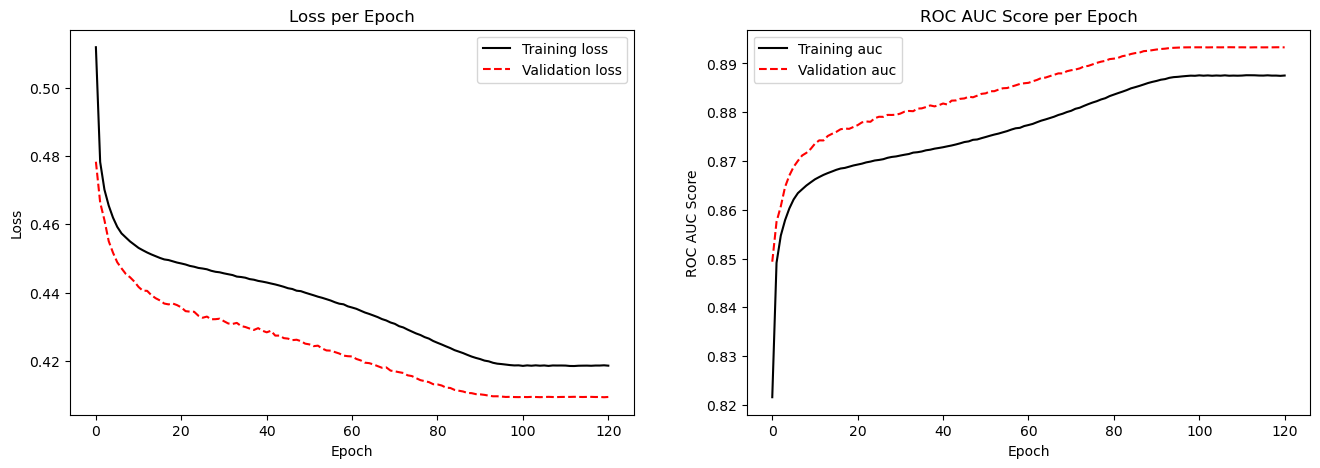

In [58]:
u.plot_training_info(HIGGS_DL_train_info, HIGGS_DL_valid_info, n="epoch", start_epoch=0)

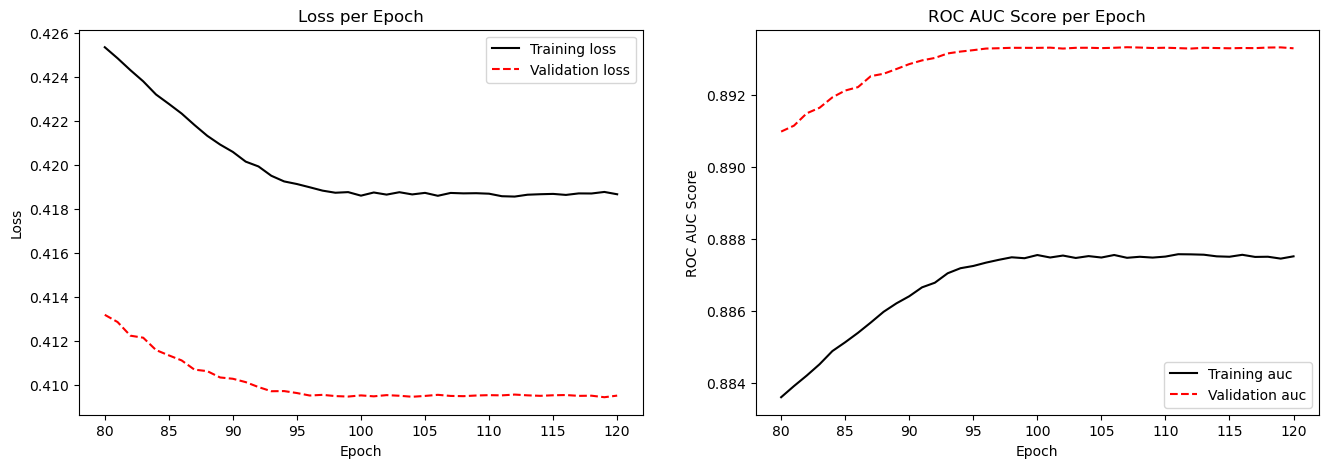

In [11]:
u.plot_training_info(HIGGS_DL_train_info, HIGGS_DL_valid_info, n="epoch", start_epoch=80)

### ROC curve of the prediction

After the training is complete, the ROC curve can be determined for the prediction of the validation set. This curve can be seen below.

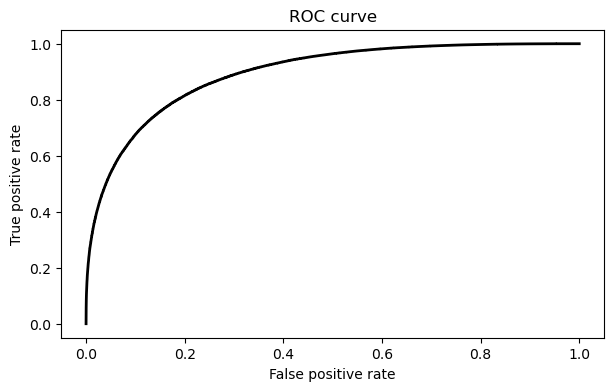

AUC score: 0.893


In [70]:
spec = importlib.util.spec_from_file_location("utils", data_dir + '\\utils.py')
u = importlib.util.module_from_spec(spec)
spec.loader.exec_module(u)

y = np.array(HIGGS_valid_labels)
p = np.array(pd.read_csv(data_dir + "\\HIGGS\\predictions\\DL_prediction_best.csv")).reshape(-1)

fpr, tpr = u.roc_curve(y, p)
auc = u.auc_from_roc(fpr, tpr)

u.plot_data(fpr, tpr, "ROC curve", None, "False positive rate", "True positive rate")

print(f"AUC score: {round(auc, 3)}")

In [7]:
HIGGS_DL_valid_pred = pd.read_csv(data_dir + "\\HIGGS\\predictions\\DL_prediction_best.csv")
HIGGS_DL_train_pred = pd.concat([pd.read_csv(data_dir + "\\HIGGS\\predictions\\DL_prediction_train_part1_best.csv"), 
                                 pd.read_csv(data_dir + "\\HIGGS\\predictions\\DL_prediction_train_part2_best.csv")], 
                               axis=0, ignore_index=True)

HIGGS_XGB_valid_pred = pd.read_csv(data_dir + "\\HIGGS\\predictions\\XGB_prediction_best.csv")
HIGGS_XGB_train_pred = pd.concat([pd.read_csv(data_dir + "\\HIGGS\\predictions\\XGB_prediction_train_part1_best.csv"), 
                                 pd.read_csv(data_dir + "\\HIGGS\\predictions\\XGB_prediction_train_part2_best.csv")], 
                               axis=0, ignore_index=True)

HIGGS_RFC_valid_pred = pd.read_csv(data_dir + "\\HIGGS\\predictions\\RFC_prediction_best.csv")
HIGGS_RFC_train_pred = pd.concat([pd.read_csv(data_dir + "\\HIGGS\\predictions\\RFC_prediction_train_part1_best.csv"), 
                                 pd.read_csv(data_dir + "\\HIGGS\\predictions\\RFC_prediction_train_part2_best.csv")], 
                               axis=0, ignore_index=True)

In [97]:
t = pd.read_csv(data_dir + "\\SUSY\\predictions\\XGB_prediction_best.csv")

print(round(roc_auc_score(SUSY_valid_labels, t), 6))

0.877811
0.87752
0.877681


In [3]:
name = "\\SUSY\\predictions\\RFC_prediction_best"
t0 = pd.read_csv(data_dir + "\\SUSY\\predictions\\RFC_prediction.csv")
t1 = pd.read_csv(data_dir + name + ".csv")
t2 = pd.read_csv(data_dir + name + "1.csv")

print(round(roc_auc_score(SUSY_valid_labels, t0), 6))
print(round(roc_auc_score(SUSY_valid_labels, t1), 6))
print(round(roc_auc_score(SUSY_valid_labels, t2), 6))

0.876292
0.876277
0.876305


In [83]:
t1.shape, t2.shape

((500000, 1), (1, 500000))

In [6]:
t0 = pd.read_csv(data_dir + "\\SUSY\\predictions\\DL_prediction.csv").T
t1 = pd.read_csv(data_dir + "\\SUSY\\predictions\\DL_prediction_best.csv").T

print(round(roc_auc_score(SUSY_valid_labels, t0), 6))
print(round(roc_auc_score(SUSY_valid_labels, t1), 6))

0.879809
0.879889


In [5]:
t0.T

,0
0,1.059211
1,-0.943937
2,-1.566394
3,1.429063
4,-1.692521
...,...
499995,2.479227
499996,0.126314
499997,-2.497195
499998,8.319640
